# <center>Anomaly Detection via Unsupervised Learning using K-means</center>
<img src="cricket.jpg" style="max-width: 20%; float: center"/>
# <center>In Search of the Anomalous Cricket!</center>

## Introduction

*Unsupervised learning* refers to machine learning techniques in which we do not give the learning algorithm a target output; for example, a set of expected classifications of the data. Instead, the algorithm must interpret the data entirely on its own without any supervision from the user.<br>

Unsupervised learning is useful when we don't have access to pre-labelled data; for example, one set of measurements may correspond to a faulty unit, whereas another set of measurements correspond to a functioning unit.<br>

Unsupervised learning is also useful when we are interested in exploring what trends exist in data (including those we may not even know about:  *UNKNOWN UNKNOWNS!*).<br>

However, the distinctions drawn in unsupervised learning are less clear-cut than in supervised learning and often involve more subjectivity in choice of parameters (this observation implies that a Neural Net may have been a better choice than K-means, but K-means is more intuitive to understand what is happening behind the magic curtain).

Applications of unsupervised learning in the context of systems administration include:
* Automated detection of abnormal events in logs
* Automated detection of anomalies time series data
 * for example, a spike in latency
* Learned models of a system, which can then be used for prediction
 * for example, a learned model of power usage effectiveness (or PUE) from machine load or outside air temperature that can then be used to investigate the effect of making a change to a variable (see Google's [Better data centers through machine learning](http://googleblog.blogspot.co.uk/2014/05/better-data-centers-through-machine.html))

## Anomaly Detection

In this project we focused on a simple example of time series anomaly detection.

This example is based on Chapter 4 (*More Complex, Adaptive Models*) from [Practical Machine Learning](https://www.safaribooksonline.com/library/view/practical-machine-learning/9781491914151/ch04.html) by Ted Dunning and Ellen Friedman.

### Simple Anomaly Detection

In the old school, we may be able to detect anomalies by looking for any values beyond a certain threshold:

<img src="simple_anomaly.jpg" style="max-width: 45%" />

In other cases, the structure of the waveform may prevent pattern detection using this method:

<img src="harder_anomaly.jpg" style="max-width: 45%" />

In the most complex cases, such as a change in the shape of a periodic waveform, the pattern will be impossible to detect with such a method:

<img src="really_hard_anomaly.jpg" style="max-width: 45%" />

What is required is a method that can learn what constitutes a "normal" waveform, not just in terms of its instantaneous value, but in terms of its *shape*.

Our approach will be to define an "anomaly" as some pattern in the waveform that hasn't been seen before. Our algorithm will build a library of "normal" waveform shapes, and use that library to try to reconstruct a waveform to be tested. If the reconstruction is poor, then the waveform is likely to contain something abnormal, and is therefore anomalous.

### Clustering

To explore how we may determine what is normal, we present a simple example:

Suppose we are manufacturing power supplies. Our power supplies use capacitors from two different manufacturers. During the QA phase we measure two variables for each unit tested: power efficiency and voltage ripple. We could plot a graph of one variable against another to get a sense of the distribution of the data:

<img src="clusters.jpg" style="max-width: 45%" />

These two variables have acceptance tolerances, as shown by the dotted lines. Within these limits, however, we find that the data tends to form two groups, or *clusters*, depending on which type of capacitor is used.

Suppose the next power supply that comes off of the assembly line meets the tolerance requirements, but falls outside either of the two groups:

<img src="clusters_anomaly.jpg" style="max-width: 45%" />

This is a sign that there may be something wrong with the unit: ANOMALY!

In this example our clusters existed in the two-dimensional space defined by two variables (or *features*). But we can visualize how the approach generalizes to a three-dimensional space defined by three features - or an *n*-dimensional space, defined by *n* features.

Clusters can be identified programatically using a *clustering* algorithm. In this project we will use *k-means clustering*.

### Waveform Space

To apply k-means to waveforms, we will need to decide how we are going to define the space in which clusters will be formed.

First, we will need to split the waveform into segments that give us separate "samples". But what will our *features* be - what are the variables that will define the *n*-dimensional space? We could go with standard measurements of each segment such as maximum, minimum, and spread. But since we want our technique to be generalisable to any number of dimensions, we can do something a bit more cool: we can take each element of the segment as a separate dimension. For a segment containing 32 time values, we define a 32-dimensional space. It is in this 32-dimensional space that we will form our clusters of waveform segments.

### Waveform Anomaly Detection

In the example of the power supplies, we detected anomalous samples based on the distance from clusters. For our waveforms, we're going to take a slightly different approach so that we can visualize what's going on.

Consider our 32-dimensional waveform space. Each point in this space represents a possible waveform segment. Similar segments will cluster together. The middle of each cluster (the *centroid*) will provide some measure of the prototypical waveform pattern that all those segments are specific instances of.

Note that the centroid, as a point in the waveform space, is itself a waveform. *Thus, the cluster centroids provide us with a set of "normal" waveform segments.*

Suppose we try to use our set of "normal" segments to reconstruct a set of data to be tested. If the data is similar in shape to what has come before it, we will be able to manage a good reconstruction. However, if the data contains some abnormal shape, we will not be able to reconstruct it using our normal shape library, and we will get a reconstruction error. THIS ERROR WILL INDICATE AN ANOMALY!

To sum up, our methodology will be:

**Training**:

* Split waveform data into segments of *n* samples
* Form a space in *n-dimensions*, with each segment representing one point
* Determine a clustering of segment points, and determine the centers or *centroids* of the clusters
* Cluster centroids provide library of "normal" waveform shapes

**Testing**:

* Try to reconstruct waveform data to be tested using cluster centroids learned during training
* Poor reconstruction error on any individual segment indicates an anomalous shape

## Our Data Set

To explore anomaly detection, we generated around 50Gb of data per day from our noisy crickets, which was then compressed and populated into our InfluxDB.

<img src="cricketlist.jpg" style="max-width: 75%; float: center"/>

Unfortunately, we used randomization in generating our data; thus our data does not possess a regular waveform (a regular waveform makes much more sense in this type of example).

<img src="cricketcode.jpg" style="max-width: 100%; float: center"/>

With a regular waveform, it is much easier to explore algorithms without having to deal with the complications that come with randomized or real-world data.

<img src="cricketoutput.jpg" style="max-width: 100%; float: center"/>

## Exploring the Cricket Data

Let's get started by importing the influxdb module and examining what the data looks like (if you can run an iPython notebook, you can try this at home!):

In [1]:
#!pip install influxdb

In [2]:
import json
from influxdb import InfluxDBClient

client_influxdb = InfluxDBClient('50.23.117.76', '8086', 'cricket', 'cricket', 'cricket_data')

query = 'SELECT "data_center", "device", "value" FROM "cricket_data"."cricket_retention"."measurement001" WHERE time > now() - 24h order by time'
result = client_influxdb.query(query)

data = []
for r in result:
  i = 0
  for data_center, device, value, time in r:
    data.append(float(r[i][value]))
#    print('measurement001','\t',r[i][data_center],'\t',r[i][device],'\t',r[i][time],'\t',r[i][value])
    i += 1

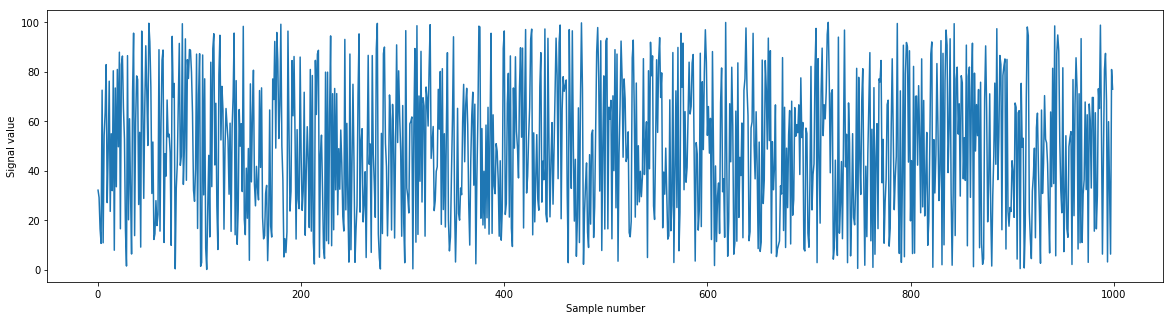

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

n_samples_to_plot = 1000
plt.figure(figsize=(20, 5))
plt.plot(data[0:n_samples_to_plot])
plt.xlabel("Sample number")
plt.ylabel("Signal value")
plt.show()

## Windowing

The first step in our process is to split the waveform into overlapping segments, with the section of the original data sampled by sliding along two samples each time. We take this approach so that we get instances of each waveform shape with a variety of horizontal translations.

In [4]:
import numpy as np

segment_len = 32
slide_len = 2

segments = []
for start_pos in range(0, len(data), slide_len):
    end_pos = start_pos + segment_len

    # make a copy so that changes to 'segments' do not modify the original data
    segment = np.copy(data[start_pos:end_pos])

    # if we are at the end and we have a truncated segment, so we drop it
    if len(segment) != segment_len:
        continue
        
    segments.append(segment)

print("Produced %d waveform segments" % len(segments))

Produced 4985 waveform segments


Let us review the segments we have produced:

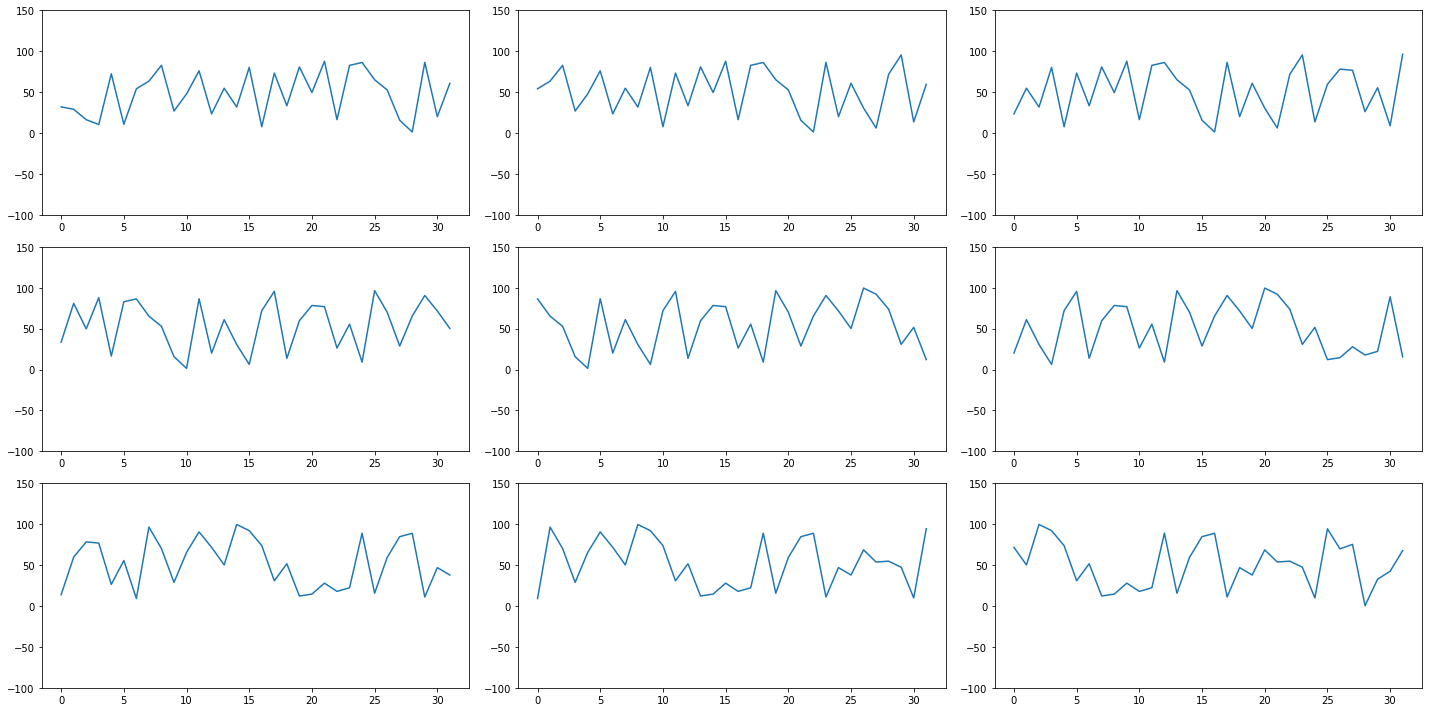

In [5]:
def plot_waves(waves, step):
    """
    Plot a set of 9 waves from the given set, starting from the first one
    and increasing in index by 'step' for each subsequent graph
    """
    plt.figure(figsize=(20, 10))
    n_graph_rows = 3
    n_graph_cols = 3
    graph_n = 1
    wave_n = 0
    for _ in range(n_graph_rows):
        for _ in range(n_graph_cols):
            axes = plt.subplot(n_graph_rows, n_graph_cols, graph_n)
            axes.set_ylim([-100, 150])
            plt.plot(waves[wave_n])
            graph_n += 1
            wave_n += step
    plt.tight_layout()
    plt.show()
    
plot_waves(segments, step=3)

Note that these segments do not necessarily begin and end with a value of zero. This could be a problem later on as the learned "normal" segment will then also have non-zero starts and ends; thus, when we attempt to reconstruct our waveform to be tested by adding together our learned segment, we will end up with discontinuities.

The way we avoid this problem is to apply a *window function* to the data which forces the start and end to be zero. A simple window function we can apply is the first half of a sine wave:

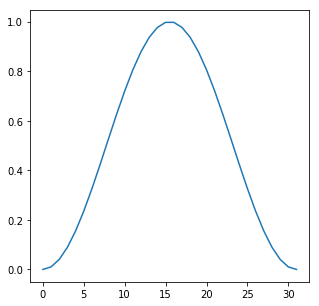

In [6]:
window_rads = np.linspace(0, np.pi, segment_len)
window = np.sin(window_rads)**2
plt.figure(figsize=(5, 5))
plt.plot(window)
plt.show()

We then multiply each segment by this window function:

In [7]:
windowed_segments = []
for segment in segments:
    windowed_segment = np.copy(segment) * window
    windowed_segments.append(windowed_segment)

Plotting the result, we see the difference that the windowing process makes. The segments are now flat at the start and end - perfect to be joined together later.

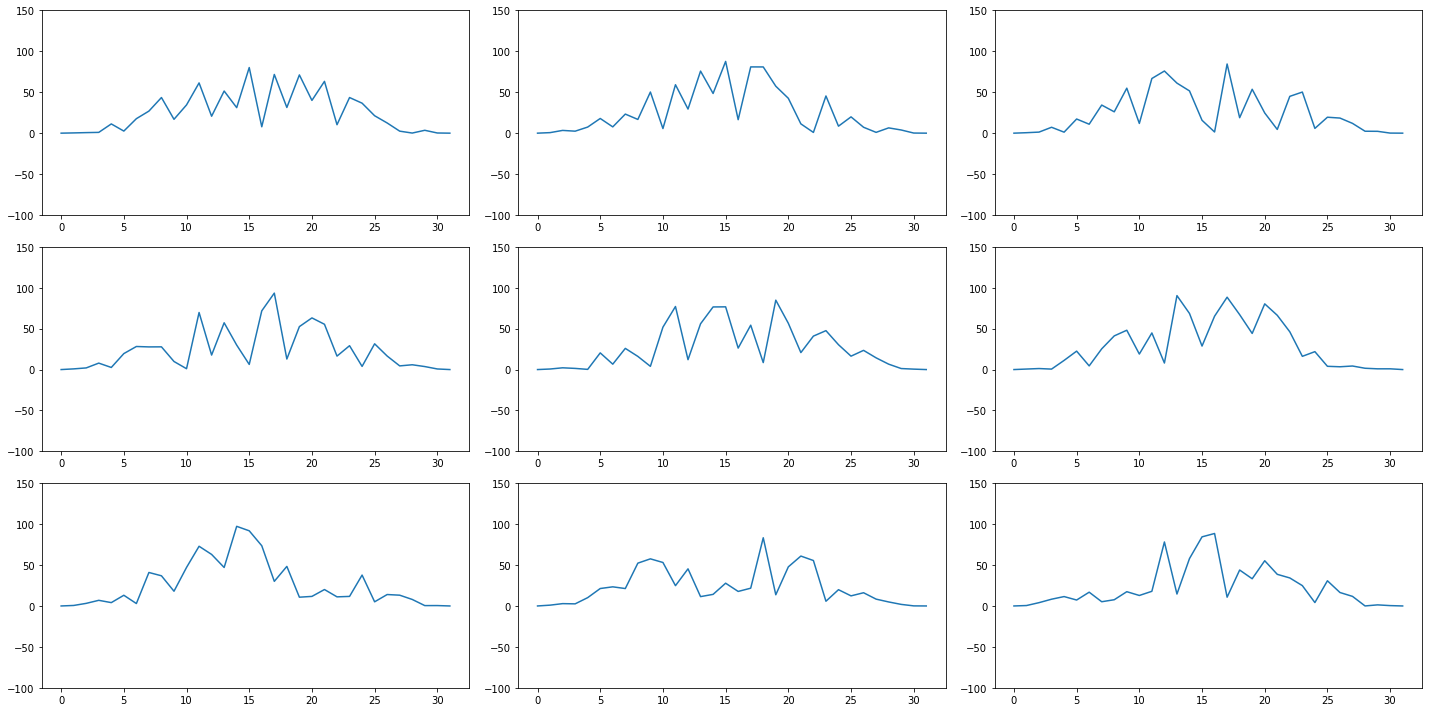

In [8]:
plot_waves(windowed_segments, step=3)

Note that windowing also has the effect of making the segments less affected by the waveform on either side of the segment. The waveform shape represented by the segment is now more "concentrated" in the middle.

## K-Means Clustering

Next, we cluster our waveform segments in 32-dimensional space.

In [9]:
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=150)
clusterer.fit(windowed_segments)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=150, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

The cluster centroids are available through the `cluster_centers` attribute. Let us take a look to see what sort of shapes K-Means has learned:

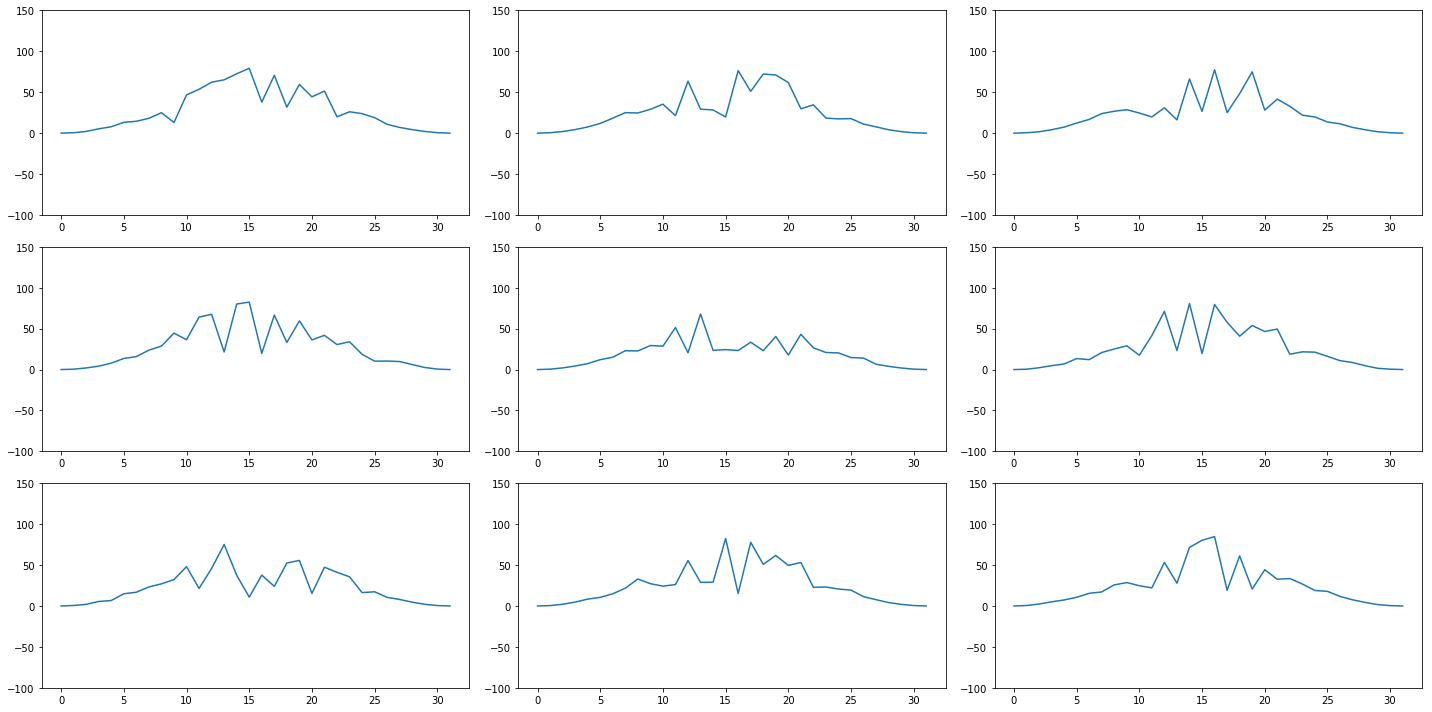

In [10]:
plot_waves(clusterer.cluster_centers_, step=15)

The clusterer appears to have learned a small number of basic shapes, with various horizontal translations. 

## Reconstruction from Clusters

Finally, we come to the interesting part of the algorithm: reconstructing our waveform to be tested using the learned library of shapes. Our approach is going to be very simple. We will:

* Split the data into overlapping segments
* Find the cluster centroid which best matches our segment
* Use that centroid as the reconstruction for that segment
* Join the reconstruction segments up to form the reconstruction

We only need enough overlap between segments to allow us to stitch the reconstructions back together again, as such we will use an overlap of half a segment.

First, let us see how well we do at reconstructing the original waveform. We first form the segments:

In [11]:
def sliding_chunker(data, window_len, slide_len):
    """
    Split a list into a series of sub-lists, each sub-list window_len long,
    sliding along by slide_len each time. If the list doesn't have enough
    elements for the final sub-list to be window_len long, the remaining data
    will be dropped.

    e.g. sliding_chunker(range(6), window_len=3, slide_len=2)
    gives [ [0, 1, 2], [2, 3, 4] ]
    """
    chunks = []
    for pos in range(0, len(data), slide_len):
        chunk = np.copy(data[pos:pos + window_len])
        if len(chunk) != window_len:
            continue
        chunks.append(chunk)

    return chunks

slide_len = segment_len / 2
test_segments = sliding_chunker (
                                data,
                                window_len = segment_len,
                                slide_len = slide_len
                                )

Before attempting to reconstruct the whole thing, we can check how the reconstruction fares for individual segments.  We try changing the segment index to see the reconstruction for different segments.

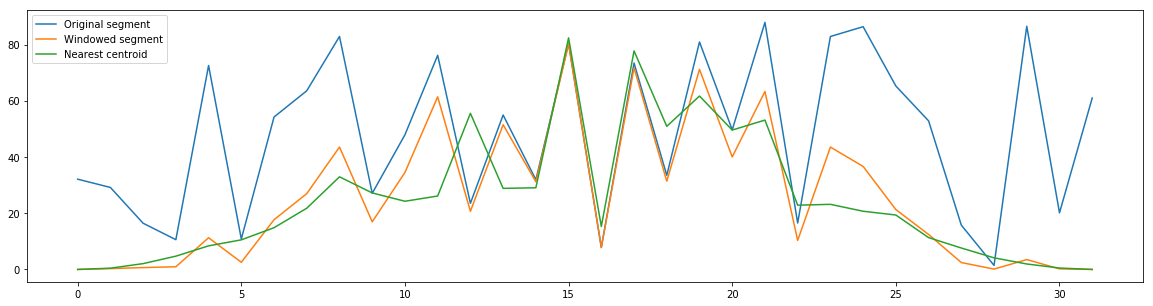

In [12]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

centroids = clusterer.cluster_centers_

segment = np.copy(test_segments[0])

# the clustering was setup using the windowed data
# so to find a match we should also window our search key

windowed_segment = segment * window

# predict() returns a list of centres to accomodate the possibility of multiple
# samples being passed

nearest_centroid_idx = clusterer.predict(windowed_segment)[0]
nearest_centroid = np.copy(centroids[nearest_centroid_idx])

plt.figure(figsize=(20, 5))
plt.plot(segment, label="Original segment")
plt.plot(windowed_segment, label="Windowed segment")
plt.plot(nearest_centroid, label="Nearest centroid")
plt.legend()
plt.show()

Now let us try to reconstruct the full set of data.

Maximum reconstruction error was 48.9
98th percentile of reconstruction error was 40.5


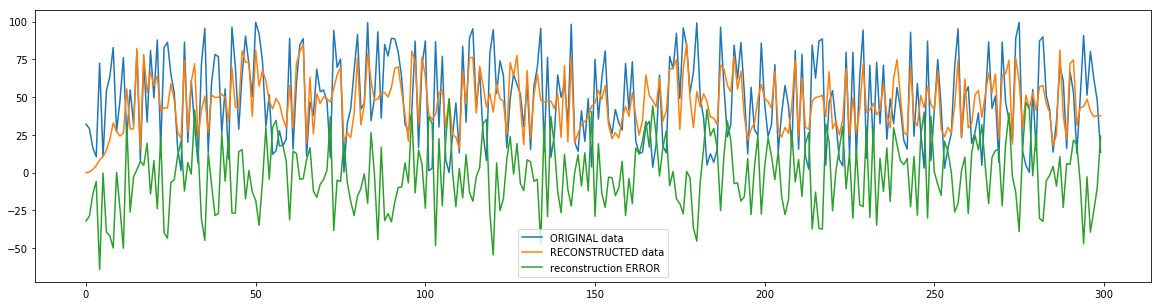

In [13]:
reconstruction = np.zeros(len(data))
slide_len = segment_len / 2

for segment_n, segment in enumerate(test_segments):
    
    # do not modify the data in segments
    segment = np.copy(segment)
    segment *= window
    nearest_centroid_idx = clusterer.predict(segment)[0]
    centroids = clusterer.cluster_centers_
    nearest_centroid = np.copy(centroids[nearest_centroid_idx])
    
    # overlay our reconstructed segments with an overlap of half a segment
    pos = segment_n * slide_len
    reconstruction[pos:pos+segment_len] += nearest_centroid

n_plot_samples = 300

error = reconstruction[0:n_plot_samples] - data[0:n_plot_samples]
error_98th_percentile = np.percentile(error, 98)
print("Maximum reconstruction error was %.1f" % error.max())
print("98th percentile of reconstruction error was %.1f" % error_98th_percentile)

plt.figure(figsize=(20, 5))
plt.plot(data[0:n_plot_samples], label="ORIGINAL data")
plt.plot(reconstruction[0:n_plot_samples], label="RECONSTRUCTED data")
plt.plot(error[0:n_plot_samples], label="reconstruction ERROR")
plt.legend()
plt.show()

## Anomaly Detection

Now that we are confident in our reconstruction algorithm, let us see what happens when we have an anomalous waveform.

*We will introduce the anomaly manually by zeroing out a small number of samples from the original:*

In [14]:
data_anomalous = np.copy(data)
data_anomalous[210:315] = 0

Then we attempt a reconstruction of this data, using the same code as above:

Maximum reconstruction error was 81.2
98th percentile of reconstruction error was 72.3


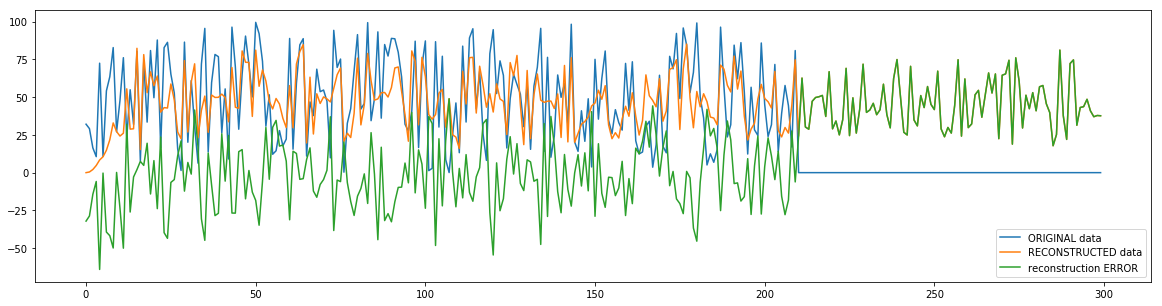

In [15]:
def reconstruct(data, window, clusterer):

    """
    Reconstruct the given data using the cluster centers from the given
    clusterer.
    """

    window_len = len(window)
    slide_len = window_len / 2
    segments = sliding_chunker(data, window_len, slide_len)
    reconstructed_data = np.zeros(len(data))

    for segment_n, segment in enumerate(segments):
        
        # window the segment so that we can find it in our clusters which were
        # formed from windowed data
        segment *= window
        nearest_match_idx = clusterer.predict(segment)[0]
        nearest_match = np.copy(clusterer.cluster_centers_[nearest_match_idx])

        pos = segment_n * slide_len
        reconstructed_data[pos:pos+window_len] += nearest_match

    return reconstructed_data

recontruction = reconstruct(data_anomalous, window, clusterer)
    
error = reconstruction[0:n_plot_samples] - data_anomalous[0:n_plot_samples]
error_98th_percentile = np.percentile(error, 98)
print("Maximum reconstruction error was %.1f" % error.max())
print("98th percentile of reconstruction error was %.1f" % error_98th_percentile)

plt.figure(figsize=(20, 5))
plt.plot(data_anomalous[0:n_plot_samples], label="ORIGINAL data")
plt.plot(reconstruction[0:n_plot_samples], label="RECONSTRUCTED data")
plt.plot(error[0:n_plot_samples], label="reconstruction ERROR")
plt.legend()
plt.show()

Since our anomaly has produced a shape in the waveform that has not been seen before, the waveform around that point could not be reconstructed using the learned shape library.

This gives us a large, easily visible reconstruction error.

This error can be detected using a simple threshold detector.

# <center>We have found the Anomalous Cricket!</center>
<img src="wilburgrasshopper.jpg" style="max-width: 20%; float: center"/>
# <center>(aka., Wilbur the Grasshopper)</center>
"Crickets tend to have long antennae, grasshoppers have short antennae." [Crickets vs. Grasshoppers](https://www.amentsoc.org/insects/fact-files/orders/orthoptera.html)

## Conclusion

We have looked at one example of the use of unsupervised learning techniques in systems administration: anomaly detection of time series data based on reconstruction error from k-means clustering.

This problem could have been solved in different ways. For example, we could have trained a predictive neural network model, and examined the difference between the predicted waveform and the actual waveform. In general, there is no 'one size fits all' solution in machine learning - different techniques will be required for different problems.